# Model comparison

To demonstrate the use of model comparison criteria, we implement the radon contamination example from the first day's material. 

Below, we fit a **pooled model**, which assumes a single fixed effect across all counties, and a **hierarchical model** that allows for a random effect that partially pools the data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", module="mkl_fft")
sns.set_context('notebook')

RANDOM_SEED = 42

The data include the observed radon levels and associated covariates for 85 counties in Minnesota.

In [2]:
radon_data = pd.read_csv('../data/radon.csv', index_col=0)
radon_data.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


### Pooled model

In [4]:
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform

floor = radon_data.floor.values
log_radon = radon_data.log_radon.values

with Model() as pooled_model:
    
    β = Normal('β', 0, sigma=1e5, shape=2)
    σ = HalfCauchy('σ', 5)
    
    θ = β[0] + β[1]*floor
    
    y = Normal('y', θ, sd=σ, observed=log_radon)
    
    trace_p = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2606.28draws/s]


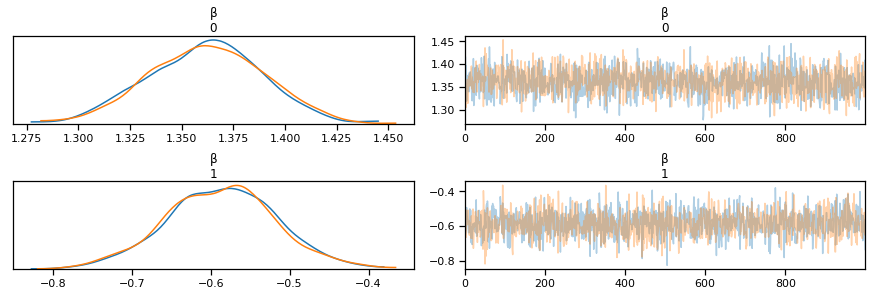

In [5]:
from arviz import plot_trace

plot_trace(trace_p, var_names=['β']);

### Unpooled model

In [6]:
counties = radon_data.county.unique()
n_counties = counties.shape[0]
county = radon_data.county.replace(dict(zip(counties, np.arange(n_counties)))).values

with Model() as unpooled_model:
    
    β0 = Normal('β0', 0, sigma=10, shape=n_counties)
    β1 = Normal('β1', 0, sigma=10)
    σ = HalfCauchy('σ', 5)
    
    θ = β0[county] + β1*floor
    
    y = Normal('y', θ, sigma=σ, observed=log_radon)
    
    trace_u = sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β1, β0]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1091.13draws/s]


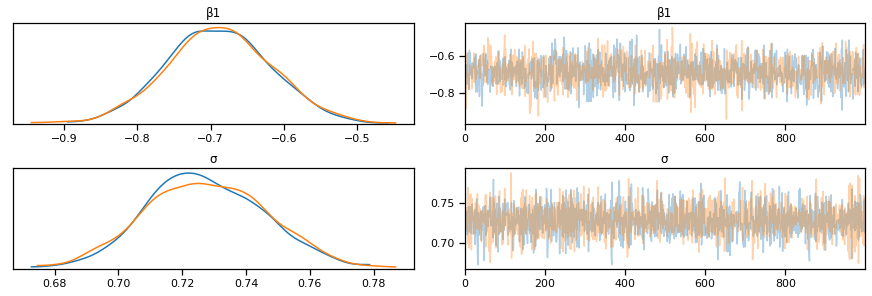

In [7]:
from arviz import plot_trace

plot_trace(trace_u, var_names=['β1', 'σ']);

### Hierarchical model

In [8]:
mn_counties = radon_data.county.unique()
counties = mn_counties.shape[0]
floor_measure = radon_data.floor.values
                             
with Model() as hierarchical_model:
    
    # Priors
    μ_b0 = Normal('μ_b0', mu=0., sigma=0.0001)
    σ_b0 = HalfCauchy('σ_b0', 5)
    
    
    # Random intercepts
    υ = Normal('υ', mu=0, sigma=1, shape=n_counties)
    β_0 = μ_b0 + υ * σ_b0
    # Common slope
    β_1 = Normal('β_1', mu=0., sigma=1e5)
    
    # Model error
    σ_y = HalfCauchy('σ_y', 5)
    
    # Expected value
    y_hat = β_0[county] + β_1 * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sd=σ_y, observed=log_radon)
    
    trace_h = sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_y, β_1, υ, σ_b0, μ_b0]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:13<00:00, 442.31draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


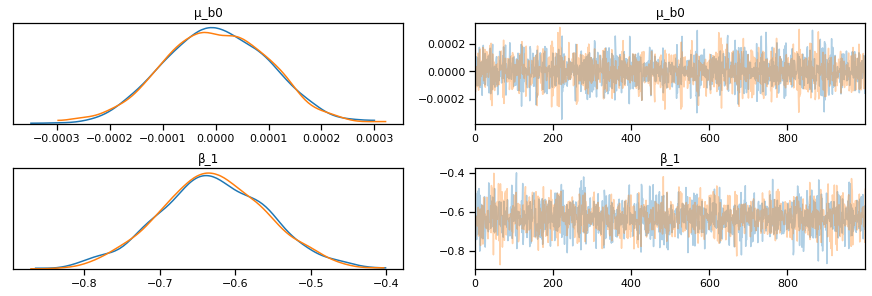

In [9]:
plot_trace(trace_h, var_names=['μ_b0', 'β_1']);

## Predictive Information Criteria

Measures of predictive accuracy are called information criteria, and are comprised of the log-predictive density of the data given a point estimate of the fitted model multiplied by −2 (i.e. the deviance):

$$−2 \log[p(y | \hat{\theta})]$$

Clearly, the expected accuracy of a fitted model’s predictions of future data will generally be lower than the accuracy of the model’s predictions for observed data, even though the parameters in the model happen to be sampled from the specified prior distribution.

Why are we interested in prediction accuracy?

1. to quantify the performance of a model
2. to perform model selection 

By model selection, we may not necessarily want to choose one model over another, but we might want to put different models on the same scale. The advantage if information-theoretic measures is that candidate models do not need to be nested; even models with completely different parameterizations can be used to predict the same measurements.

Note that when candidate models have the same number of parameters, one can compare their best-fit log predictive densities directly, but when model dimensions differ, one has to make an adjustment for the tendency of a larger model to fit data better.

One advantage of using predictive information criteria for model comparison is that they allow us to estimate out-of-sample predictive accuracy using the data in our sample. All such methods are approximations of predictive accuracy, so they are not perfect, but they perform reasonably well.

One can naively use the log predictive density for the sample data (within-sample predictive accuracy) as an approximation of the out-of-sample predictive accuracy, but this will almost always result in an overestimate of performance.

As is popular in machine learning, cross-validation can be used to evaluate predictive accuracy, whereby the dataset is partitioned and each partition is allowed to be used to fit the model and evaluate the fit. However, this method is computationally expensive because it reqiures the same model to be fit to multiple subsets of the data.

We will focus here on adjusted within-sample predictive accuracy, using a variety of information criteria. The goal here is to get an approximately unbiased estimate of predictive accuracy which are correct in expectation.

### AIC and DIC

One approach to model selection is to use an information-theoretic criterion to identify the most appropriate model. Akaike (1973) found a formal relationship between Kullback-Leibler information (a dominant paradigm in information and coding theory) and likelihood theory. Akaike's Information Criterion (AIC) is an estimator of expected relative K-L information based on the maximized log-likelihood function, corrected for asymptotic bias.

$$\text{AIC} = −2 \log(L(\theta|data)) + 2K$$

AIC balances the fit of the model (in terms of the likelihood) with the number of parameters required to achieve that fit. We can easily calculate AIC from the residual sums of squares as:

$$\text{AIC} = n \log(\text{RSS}/n) + 2k$$

where $k$ is the number of parameters in the model. Notice that as the number of parameters increase, the residual sum of squares goes down, but the second term (a penalty) increases.

A limitation of AIC for Bayesian models is that it cannot be applied to hierarchical models (or any models with random effects), as counting the number of parameters in such models is problematic. A more Bayesian version of AIC is called the deviance information criterion (DIC), and replaces the fixed parameter penalty with an estimate of the effective number of parameters.

$$p_{DIC} = 2\left(\log p(y | E[\theta | y]) - E_{post}[\log p(y|\theta)] \right)$$

where the second term is an average of $\theta$ over the posterior distribution:

$$\hat{p}_{DIC} = 2\left(\log p(y | E[\theta | y]) - \frac{1}{M} \sum_{j=1}^{M}\log p(y|\theta^{(j)}) \right)$$

DIC is computed as:

$$\text{DIC} = -2 \log p(y | E[\theta | y]) + 2p_{DIC}$$

Though this is an improvement over AIC, DIC is still not fully Bayesian, as it relies on a point estimate of the model rather than using the full posterior. As a result, it can be unstable for hierarchical models, sometimes producing estimates of effective number of parameters that is negative.

### Widely-applicable Information Criterion (WAIC)

WAIC (Watanabe 2010) is a fully Bayesian criterion for estimating out-of-sample expectation, using the log pointwise posterior predictive density (LPPD) and correcting for the effective number of parameters to adjust for overfitting.

The computed log pointwise predictive density is:

$$lppd_{comp} = \sum_{i=1}^N \log \left(\frac{1}{M} \sum_{j=1}^M p(y_i | \theta^{(j)}) \right)$$

The complexity adjustment here is as follows:

$$p_{WAIC} = 2\sum_{i=1}^N \left[ \log \left(\frac{1}{M} \sum_{j=1}^M p(y_i | \theta^{(j)})\right)  - \frac{1}{M} \sum_{j=1}^M \log p(y_i | \theta^{(j)})  \right]$$

so WAIC is then:

$$\text{WAIC} = -2(lppd) + 2p_{WAIC}$$

The adjustment is an approximation to the number of unconstrained parameters in the model (0=fully constrained, 1=no constraints). In this sense, WAIC treats the effective number of paramters as a random variable.

WAIC averages over the posterior distribution, and therefore is more reliable for a wider range of models.

In [9]:
from arviz import waic

pooled_waic = waic(trace_p, pooled_model)
    
pooled_waic

Computed from 2000 by 919 log-likelihood matrix

        Estimate       SE
IC_waic  2179.83    50.05
p_waic      3.78        -

In [10]:
unpooled_waic = waic(trace_u, unpooled_model)
    
unpooled_waic

/home/colin/miniconda3/envs/bayes_course/lib/python3.6/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 919 log-likelihood matrix

        Estimate       SE
IC_waic  2117.08    56.74
p_waic     82.90        -

There has been a warning during the calculation. Please check the results.

In [11]:
hierarchical_waic = waic(trace_h, hierarchical_model)
    
hierarchical_waic

Computed from 2000 by 919 log-likelihood matrix

        Estimate       SE
IC_waic  2115.00    55.86
p_waic     80.19        -

There has been a warning during the calculation. Please check the results.

PyMC3 includes two convenience functions to help compare WAIC for different models. The first of this functions is `compare`, this one computes WAIC (or LOO) from a set of traces and models and returns a DataFrame.

In [12]:
from arviz import compare

df_comp_WAIC = compare({'hierarchical':trace_h, 'pooled':trace_p, 'unpooled':trace_u}, ic='waic', seed=RANDOM_SEED)
df_comp_WAIC

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
hierarchical,0,2115,80.1949,0,0.648836,55.4103,0,True,deviance
unpooled,1,2117.08,82.9048,2.07431,0.338239,49.8453,4.25794,True,deviance
pooled,2,2179.83,3.77706,64.8332,0.0129245,56.3414,28.4348,False,deviance


We have many columns so let check one by one the meaning of them:

1. The first column is the rank order of the models; zero is best.

2. The second column contains the values of WAIC. The DataFrame is always sorted from lowest to highest WAIC. The index reflects the order in which the models are passed to this function.

3. The third column is the relative difference between the value of WAIC for the top-ranked model and the value of WAIC for each model. For this reason we will always get a value of 0 for the first model.

4. The second column is the estimated effective number of parameters. In general, models with more parameters will be more flexible to fit data and at the same time could also lead to overfitting. Thus we can interpret pWAIC as a penalization term, intuitively we can also interpret it as measure of how flexible each model is in fitting the data. 

5. Sometimes when comparing models, we do not want to select the "best" model, instead we want to perform predictions by averaging along all the models (or at least several models). Ideally we would like to perform a weighted average, giving more weight to the model that seems to explain/predict the data better. There are many approaches to perform this task, one of them is to use Akaike weights based on the values of WAIC for each model. These weights can be loosely interpreted as the probability of each model (among the compared models) given the data. One caveat of this approach is that the weights are based on point estimates of WAIC (i.e. the uncertainty is ignored).

6. The sixth column records the standard error for the WAIC computations. The standard error can be useful to assess the uncertainty of the WAIC estimates. Nevertheless, caution need to be taken because the estimation of the standard error assumes normality and hence could be problematic when the sample size is low.

7. In the same way that we can compute the standard error for each value of WAIC, we can compute the standard error of the differences between two values of WAIC. Notice that both quantities are not necessarily the same, the reason is that the uncertainty about WAIC is correlated between models. This quantity is always 0 for the top-ranked model.

8. dSE is the standard error of the difference in IC between each model and the top-ranked model. It’s always 0 for the top-ranked model.

9. The second-last column is a flag for warnings. A value of `True` indicates that the computation of WAIC may not be reliable, this warning is based on an empirical determined cutoff value and need to be interpreted with caution. For more details you can read this [paper](https://arxiv.org/abs/1507.04544).

10. The last column indicates the scale used for the information criterion.

The second convenience function takes the output of `compare` and produces a summary plot in the style of the one used in the book [Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/) by Richard McElreath (check also [this port](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3) of the examples in the book to PyMC3).

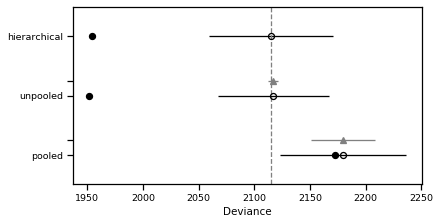

In [13]:
from arviz import plot_compare

ax = plot_compare(df_comp_WAIC);

- The empty circle represents the values of WAIC and the black error bars associated with them are the values of the standard deviation of WAIC. 
- The value of the lowest WAIC is also indicated with a vertical dashed grey line to ease comparison with other WAIC values.
- The filled black dots are the in-sample deviance of each model, which for WAIC is  2 pWAIC from the corresponding WAIC value.

For all models except the top-ranked one we also get a triangle indicating the value of the difference of WAIC between that model and the top model and a grey errobar indicating the standard error of the differences between the top-ranked WAIC and WAIC for each model.

### Leave-one-out Cross-validation (LOO)

LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. 

The estimate of out-of-sample predictive fit from applying LOO cross-validation to a Bayesian model is:

$$lppd_{loo} = \sum_{i=1}^N \log p_{post(-i)}(y_i) =  \sum_{i=1}^N \log \left(\frac{1}{S} \sum_{s=1}^S p(y_i| \theta^{(is)})\right)$$

so, each prediction is conditioned on $N-1$ data points, which induces an underestimation of the predictive fit for smaller $N$. The resulting estimate of effective samples size is:

$$p_{loo} = lppd - lppd_{loo}$$

As mentioned, using cross-validation for a Bayesian model, fitting $N$ copies of the model under different subsets of the data is computationally expensive. However, Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples, which are corrected using Pareto-smoothed importance sampling (PSIS) to provide an estimate of point-wise out-of-sample prediction accuracy.

This involves estimating the importance sampling LOO predictive distribution

$$p(\tilde{y}_i | y_{-i}) \approx \frac{\sum_{s=1}^S w_i(\theta^{(s)}) p(\tilde{y}_i|\theta^{(s)})}{\sum_{s=1}^S w_i(\theta^{(s)})}$$

where the importance weights are:

$$w_i(\theta^{(s)}) = \frac{1}{p(y_i | \theta^{(s)})} \propto \frac{p(\theta^{(s)}|y_{-i})}{p(\theta^{(s)}|y)}$$

The predictive distribution evaluated at the held-out point is then:

$$p(y_i | y_{-i}) \approx \frac{1}{\frac{1}{S} \sum_{s=1}^S \frac{1}{p(y_i | \theta^{(s)})}}$$

However, the posterior is likely to have a smaller variance and thinner tails than the LOO posteriors, so this approximation induces instability due to the fact that the importance ratios can have high or infinite variance.
To deal with this instability, a generalized Pareto distribution fit to the upper tail of the distribution of the importance ratios can be used to construct a test for a finite importance ratio variance. If the test suggests the variance is infinite then importance sampling is halted.

LOO using using Pareto-smoothed importance sampling is implemented in PyMC3 in the `loo` function.

In [14]:
from arviz import loo

pooled_loo = loo(trace_p, pooled_model)
    
pooled_loo

Computed from 2000 by 919 log-likelihood matrix

       Estimate       SE
IC_loo  2179.84    50.05
p_loo      3.78        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      919  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [15]:
unpooled_loo = loo(trace_u, unpooled_model)
    
unpooled_loo

/home/colin/miniconda3/envs/bayes_course/lib/python3.6/site-packages/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 2000 by 919 log-likelihood matrix

       Estimate       SE
IC_loo  2124.25    57.05
p_loo     86.49        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      879   95.6%
 (0.5, 0.7]   (ok)         34    3.7%
   (0.7, 1]   (bad)         5    0.5%
   (1, Inf)   (very bad)    1    0.1%

In [16]:
hierarchical_loo  = loo(trace_h, hierarchical_model)
    
hierarchical_loo

/home/colin/miniconda3/envs/bayes_course/lib/python3.6/site-packages/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 2000 by 919 log-likelihood matrix

       Estimate       SE
IC_loo  2121.90    55.93
p_loo     83.65        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      890   96.8%
 (0.5, 0.7]   (ok)         23    2.5%
   (0.7, 1]   (bad)         5    0.5%
   (1, Inf)   (very bad)    1    0.1%

We can also use `compare` with LOO.

In [17]:
df_comp_LOO = compare({'hierarchical':trace_h, 'pooled':trace_p, 'unpooled':trace_u}, ic='LOO', seed=RANDOM_SEED)
df_comp_LOO

/home/colin/miniconda3/envs/bayes_course/lib/python3.6/site-packages/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/colin/miniconda3/envs/bayes_course/lib/python3.6/site-packages/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential 

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
hierarchical,0,2121.9,83.6464,0,0.649619,55.423,0,True,deviance
unpooled,1,2124.25,86.4937,2.34908,0.327092,49.8461,5.12591,True,deviance
pooled,2,2179.84,3.77836,57.9327,0.0232894,56.6465,28.6248,False,deviance


We can also plot the results

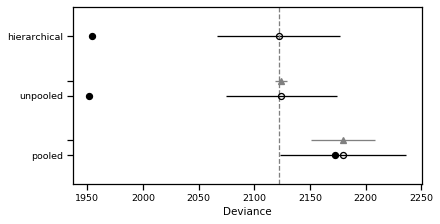

In [18]:
plot_compare(df_comp_LOO);

### Interpretation

Though we might expect the hierarchical model to outperform non-hierarchical models, there is little to choose between the models in this case, giving that all models give similar values of the information criteria (particularly the top two). This is more clearly appreciated when we take into account the uncertainty (in terms of standard errors) of WAIC and LOO.

## Exercise: Rat tumors

Suppose we are interested in the probability that a lab rat develops endometrial stromal polyps.  We have data from 71 previously performed trials and would like to use this data to perform inference.

The authors of BDA3 choose to model this problem heirarchically.  Let $y_i$ be the number of lab rats which develop endometrial stromal polyps out of a possible $n_i$.  We model the number rodents which develop endometrial stromal polyps as binomial

$$ y_i \sim \operatorname{Bin}(\theta_i;n_i)$$

allowing the probability of developing an endometrial stromal polyp (i.e. $\theta_i$) to be drawn from some population distribution.  For analytical tractability, we assume that $\theta_i$ has Beta distribution

$$ \theta_i \sim \operatorname{Beta}(\alpha, \beta)$$

We are free to specify a prior distribution for $\alpha, \beta$.  We choose a weakly informative prior distribution to reflect our ignorance about the true values of $\alpha, \beta$.  The authors of BDA3 choose the joint hyperprior for $\alpha, \beta$ to be

$$ p(\alpha, \beta) \propto (\alpha + \beta) ^{-5/2}$$

Specify a couple of different models, and compare them using IC.

In [10]:
# rat data (BDA3, p. 102)
y = np.array([
    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
    1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
    5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])

N = len(n)

In [18]:
#MLE:
y.sum()/n.sum()

0.1535365152386429

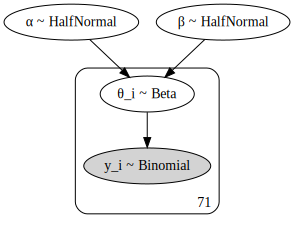

In [24]:
# In the below:
# i represents the trial (up to N)
# 
import pymc3 as pm

with Model() as rat_model_1:
    α = pm.HalfNormal('α', 1)
    β = pm.HalfNormal('β', 1)
    θ_i = pm.Beta('θ_i', α, β, shape=N)
    y_i = pm.Binomial('y_i', p=θ_i, n=n, observed=y, shape=N)

pm.model_to_graphviz(rat_model_1)

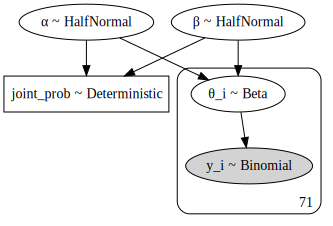

In [32]:
# In the below:
# i represents the trial (up to N)
# 
import pymc3 as pm

with Model() as rat_model_2:
    α = pm.HalfNormal('α', 1)
    β = pm.HalfNormal('β', 1)
    joint_prob = pm.Potential('joint_prob', (α + β)**(-5/2))
    θ_i = pm.Beta('θ_i', α, β, shape=N)
    y_i = pm.Binomial('y_i', p=θ_i, n=n, observed=y, shape=N)

pm.model_to_graphviz(rat_model_2)

In [25]:
with rat_model_1:
    rat_1_sample = pm.sample(model=rat_model_1, )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ_i, β, α]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1344.29draws/s]


/usr/local/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/plots/plot_utils.py:506: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (71) in plot_posterior, generating only 40 plots
  SyntaxWarning,


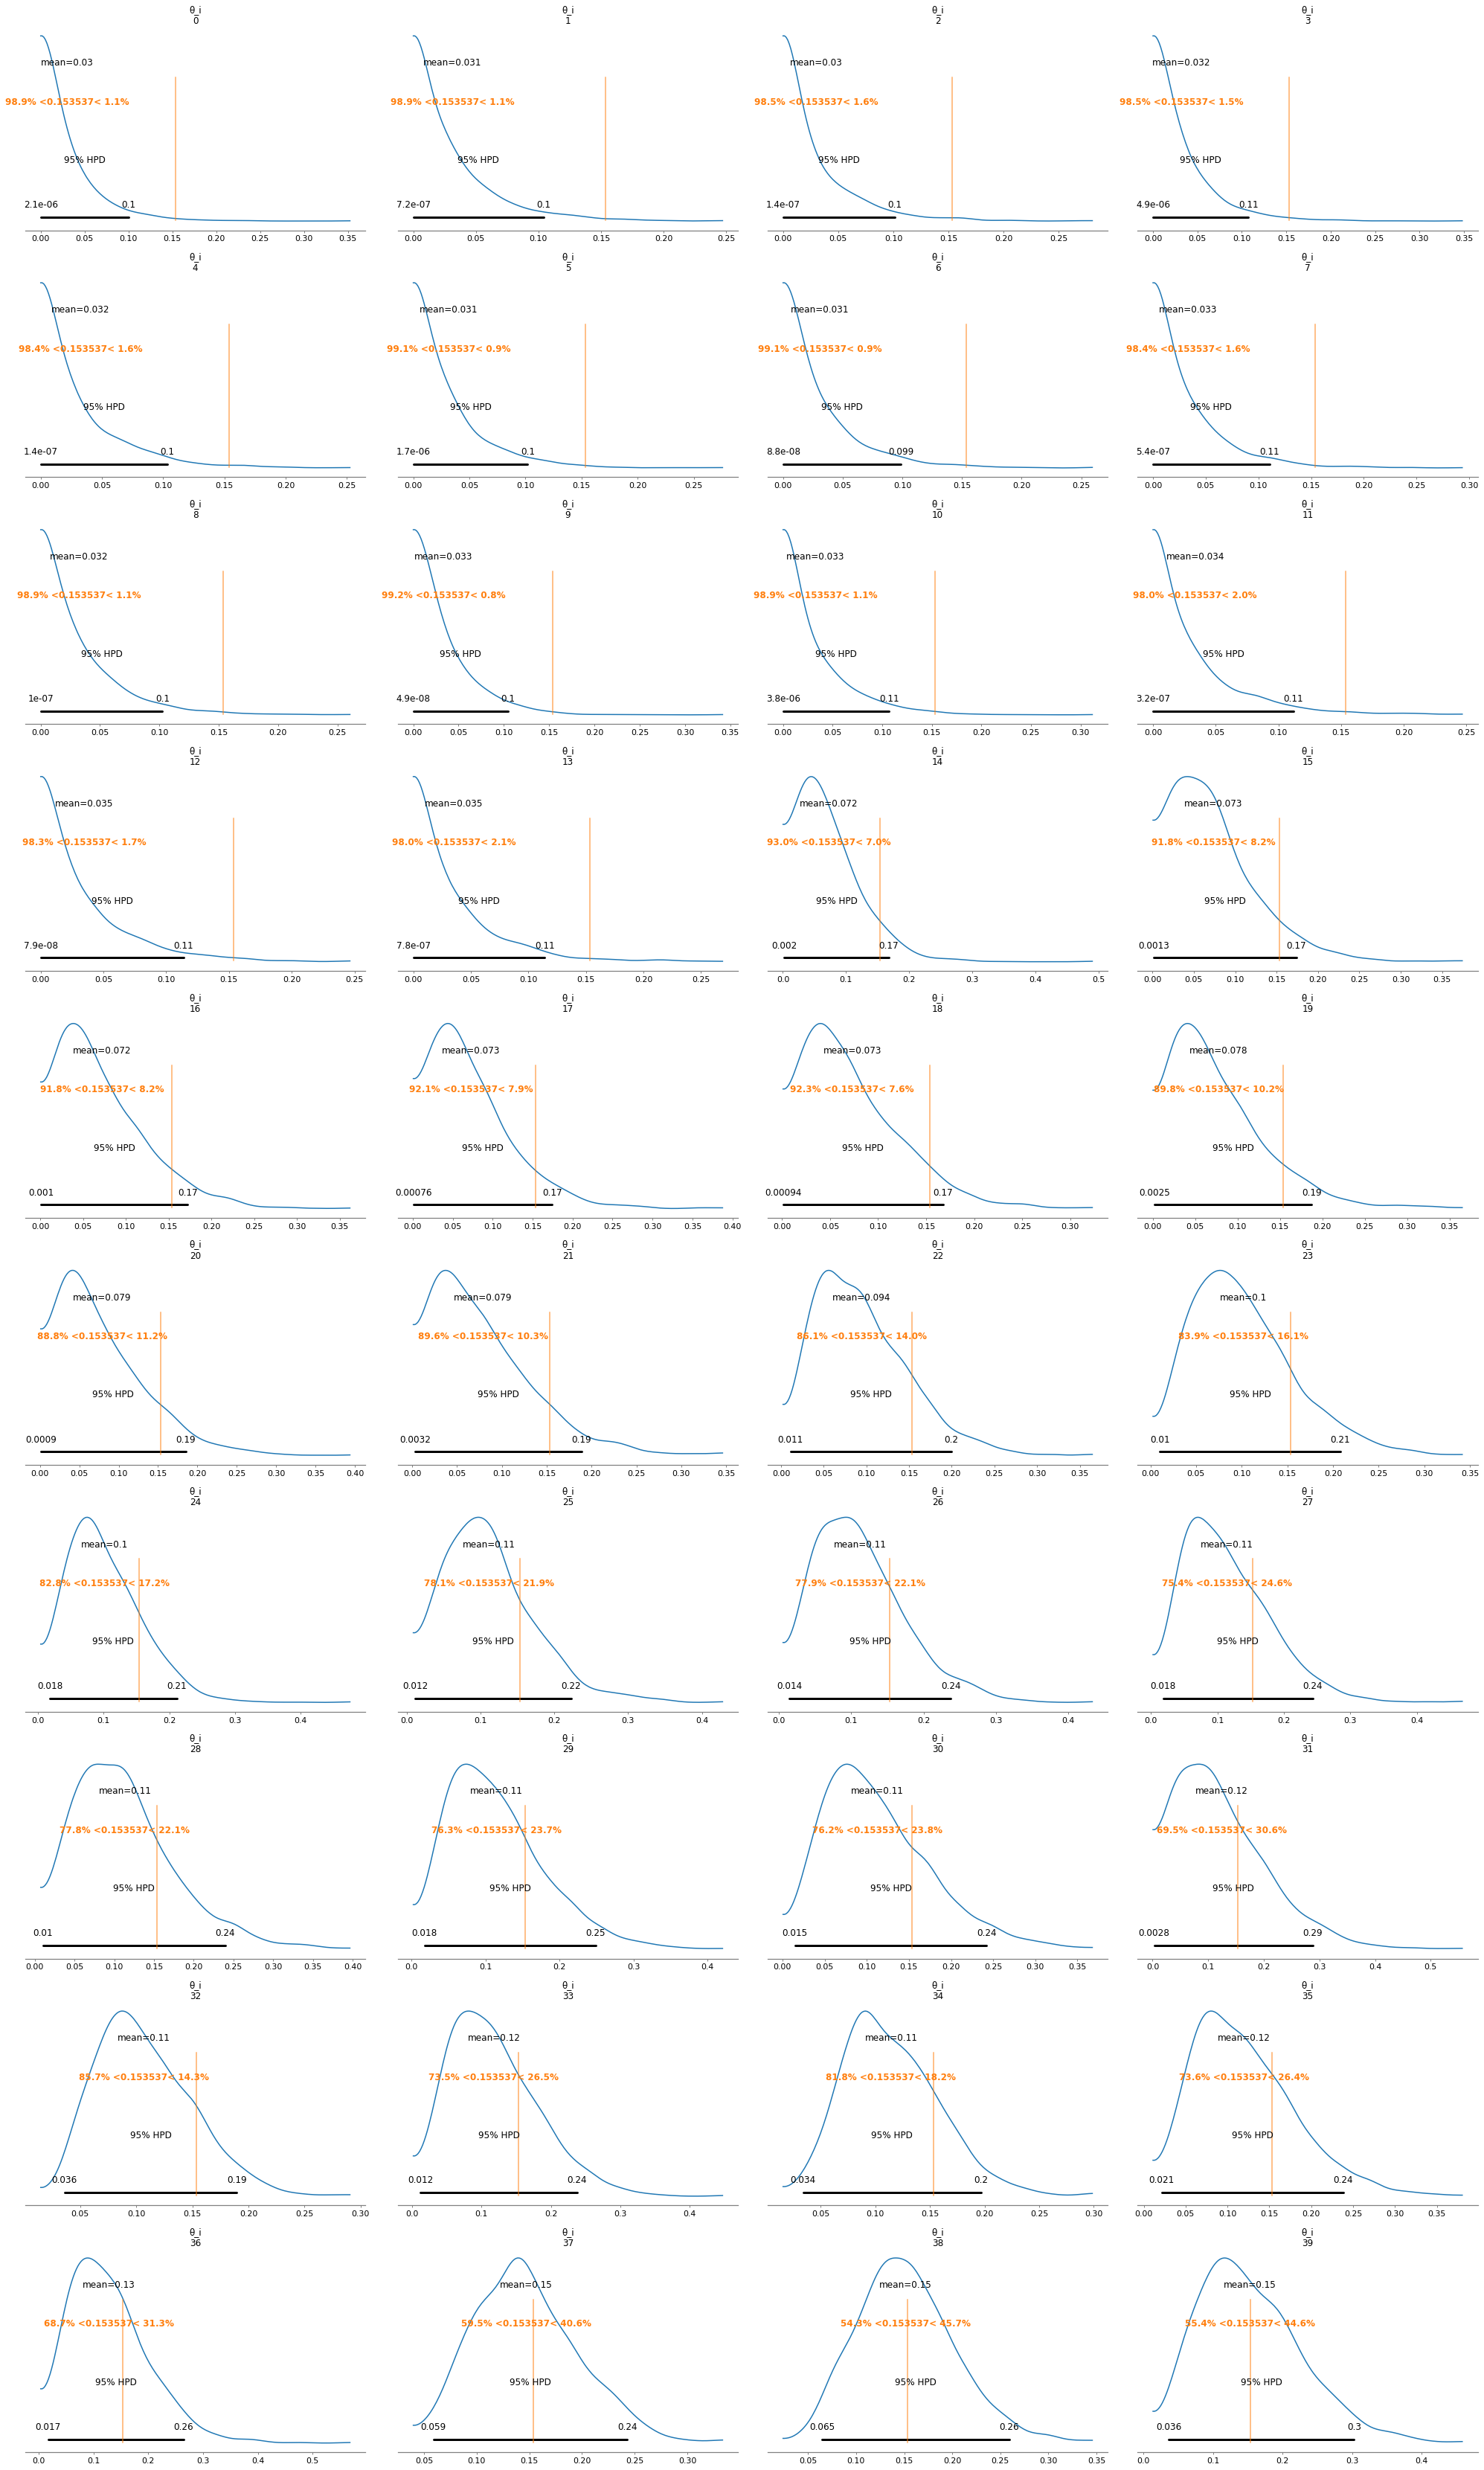

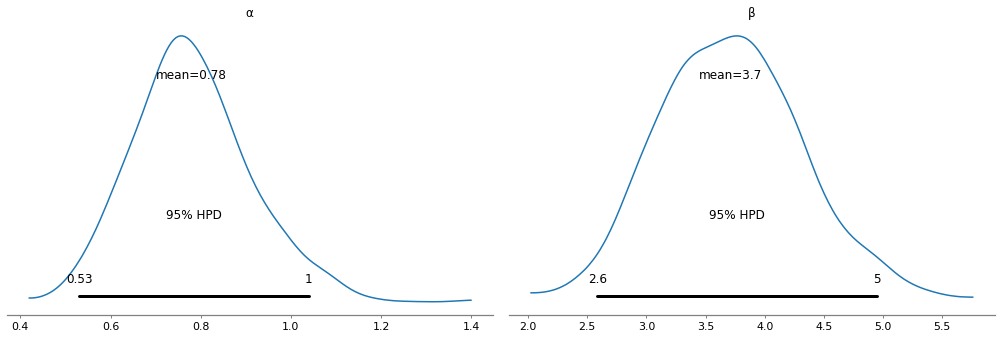

In [26]:
import arviz as az

az.plot_posterior(rat_1_sample, var_names=['θ_i'], ref_val=y.sum()/n.sum(), credible_interval=0.95, kind='kde');

az.plot_posterior(rat_1_sample, var_names=['α', 'β'], credible_interval=0.95, kind='kde'); 

In [30]:
az.waic(rat_1_sample)

/usr/local/anaconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 2000 by 71 log-likelihood matrix

        Estimate       SE
IC_waic   277.22     9.85
p_waic     29.75        -

There has been a warning during the calculation. Please check the results.

In [20]:

df_comp_WAIC = compare({'hierarchical':trace_h, 'pooled':trace_p, 'unpooled':trace_u}, ic='waic', seed=RANDOM_SEED)
df_comp_WAIC


---

## Reference

[Burnham, K. and Anderson, K. (2013). Model Selection and Multimodel Inference: A Practical Information-Theoretic Approach](https://www.amazon.co.uk/Model-Selection-Multimodel-Inference-Information-Theoretic/dp/1441929738)

[Gelman, A., Hwang, J., & Vehtari, A. (2014). Understanding predictive information criteria for Bayesian models. Statistics and Computing, 24(6), 997–1016.](http://doi.org/10.1007/s11222-013-9416-2)

[Vehtari, A, Gelman, A, Gabry, J. (2016). Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. Statistics and Computing](http://link.springer.com/article/10.1007/s11222-016-9696-4)